In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from time import time

## Importando os dados

In [2]:
df = pd.read_csv('./star_classification.csv', sep=',').replace('?', np.nan)
df = df.drop(['obj_ID', 'run_ID', 'rerun_ID', 'field_ID', 'spec_obj_ID', 'fiber_ID'], axis=1) # there is no need for id columns
print(df.shape)
df.head()

(100000, 12)


,alpha,delta,u,g,r,i,z,cam_col,class,redshift,plate,MJD
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,2,GALAXY,0.634794,5812,56354
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,5,GALAXY,0.779136,10445,58158
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,2,GALAXY,0.644195,4576,55592
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,3,GALAXY,0.932346,9149,58039
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,3,GALAXY,0.116123,6121,56187


## Análises iniciais

In [3]:
# Após análise inicial dos dados decidi fazer remoção dessas linhas
df = df[df['u'] > -5000]
df.shape # na verdade só uma linha foi deletada, comento mais depois

(99999, 12)

In [4]:
df.describe()

,alpha,delta,u,g,r,i,z,cam_col,redshift,plate,MJD
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,177.628653,24.135552,22.080679,20.631583,19.645777,19.084865,18.768988,3.511625,0.576667,5137.027890,55588.653687
std,96.502612,19.644608,2.251068,2.037384,1.854763,1.757900,1.765982,1.586913,0.730709,2952.312485,1808.492217
min,0.005528,-18.785328,10.996230,10.498200,9.822070,9.469903,9.612333,1.000000,-0.009971,266.000000,51608.000000
25%,127.517698,5.147477,20.352410,18.965240,18.135795,17.732280,17.460830,2.000000,0.054522,2526.000000,54234.000000
50%,180.900527,23.646462,22.179140,21.099930,20.125310,19.405150,19.004600,4.000000,0.424176,4987.000000,55869.000000
75%,233.895005,39.901582,23.687480,22.123775,21.044790,20.396510,19.921120,5.000000,0.704172,7400.500000,56777.000000
max,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,6.000000,7.011245,12547.000000,58932.000000


<Axes: xlabel='class', ylabel='Count'>

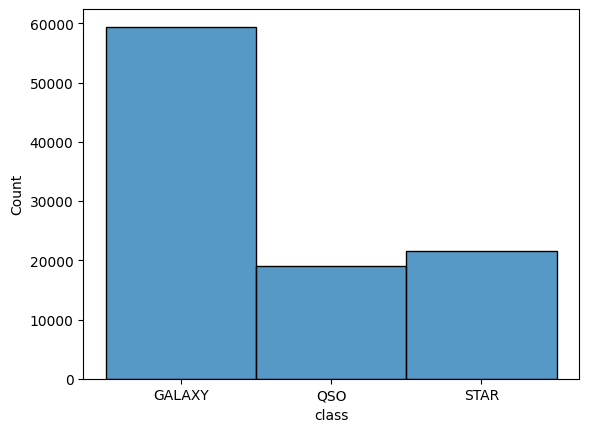

In [5]:
# apenas coluna 'class' com valores categóricos
sns.histplot(data=df.loc[:,'class'])

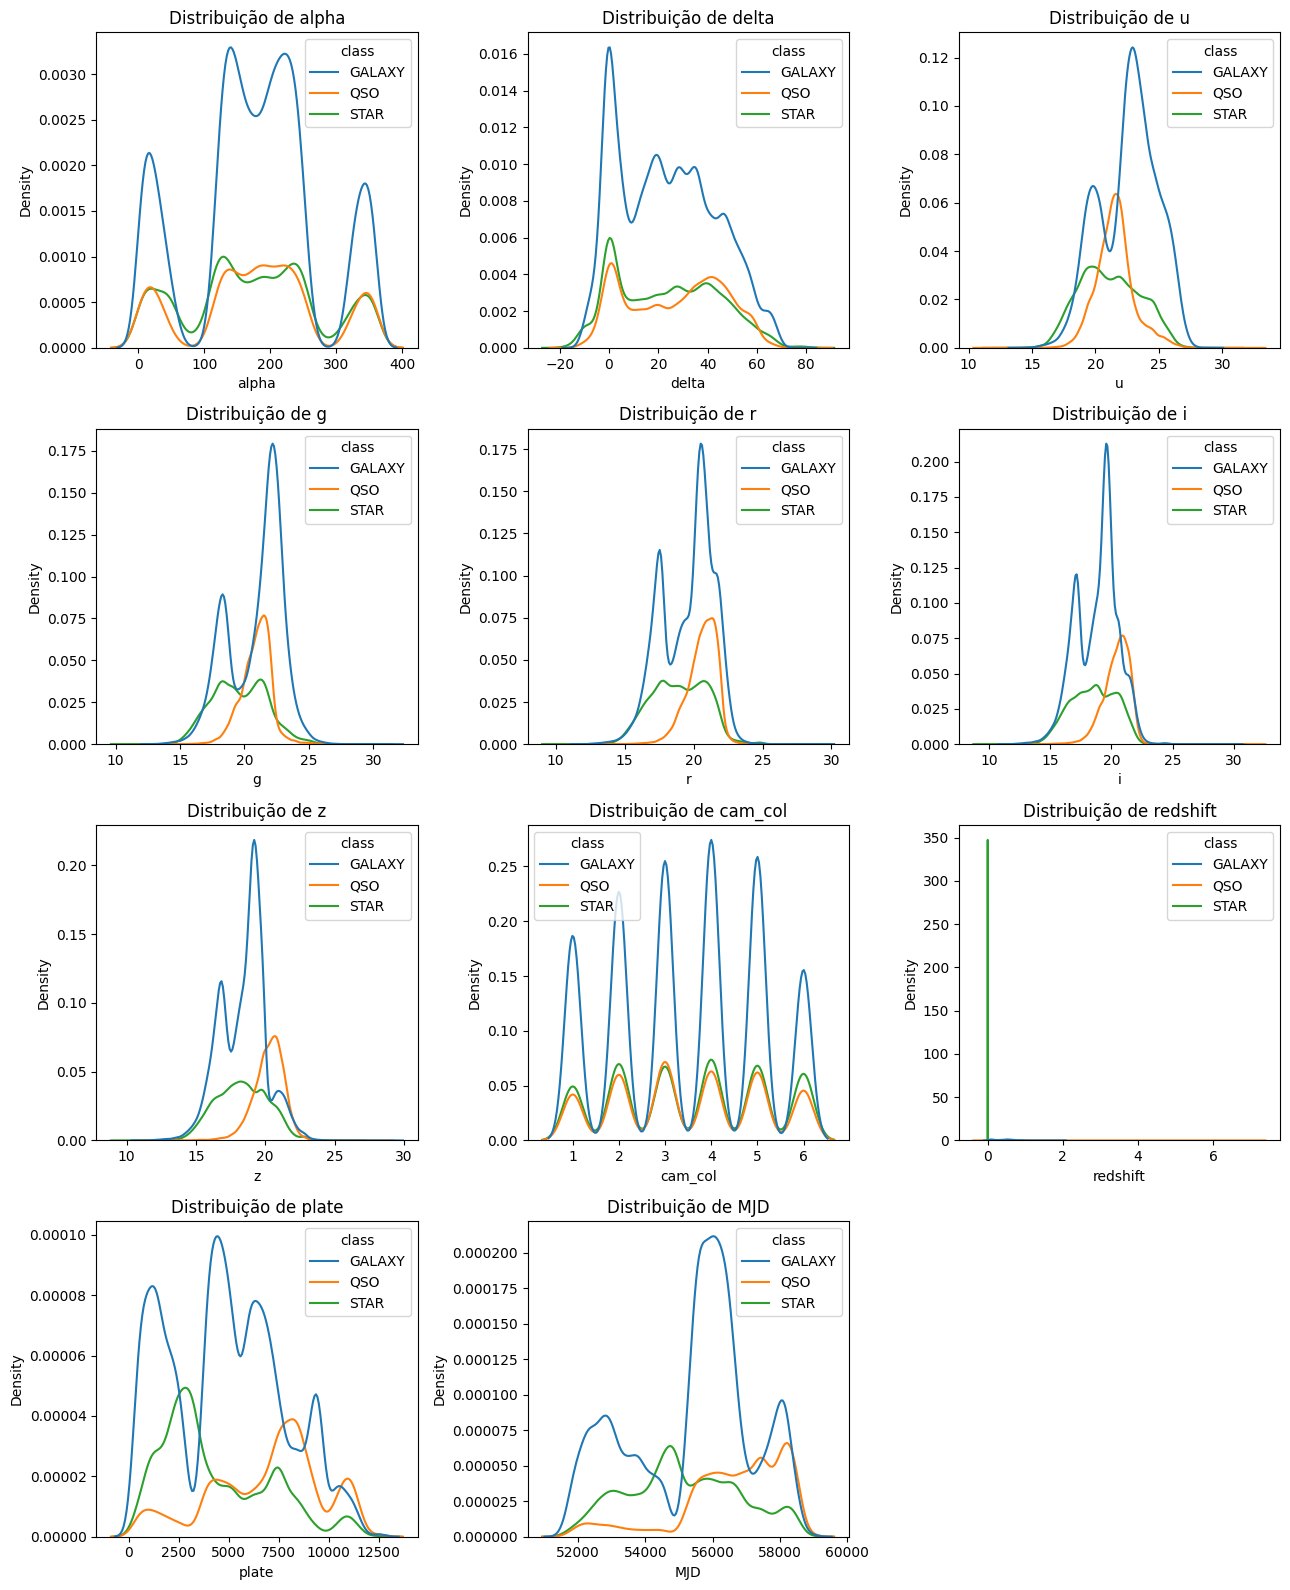

In [6]:
# calculando distribuição para colunas com valores numéricos
n_rows = df.shape[1]//3
num_data = [i for i in list(df.columns) if i != 'class']

fig, axes = plt.subplots(n_rows, 3, figsize=(13, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_data):    
    sns.kdeplot(data=df, x=col, hue='class', ax=axes[i])
    axes[i].set_title(f'Distribuição de {col}')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

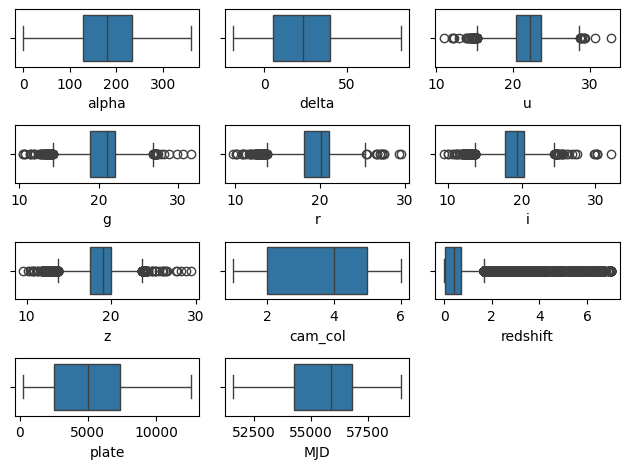

In [7]:
# detectando outliers
fig, axes = plt.subplots(n_rows, 3)
axes = axes.flatten()

for i, col in enumerate(num_data):
    # gerando boxplot
    sns.boxplot(data=df.loc[:,col], orient='h', ax=axes[i])

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [8]:
# convertendo label para valor numérico
# df.loc[:,'class'] = df.loc[:,'class'].map({v: i for i, v in enumerate(pd.unique(df['class']))})
labels = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit_transform(pd.DataFrame(df.loc[:,'class']))

*Observações:* Podemos ver que se trata de um problema desbalanceado. Detectei alguns outliers principalmente nas colunas 'u', 'g', e 'z', que foram removidos para melhorar a visualização dos dados. Resolvi manter os outliers da coluna 'redshift'.

## Definindo DataLoader e Modelo

In [9]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

In [10]:
class NeuralNetwork(nn.Module):

    def __init__(self, input_dim=11, n_features=3, n_hidden_layers=1, width=16):
        super().__init__()
        self.input_layer = nn.Sequential(nn.Linear(input_dim, width),
                                         nn.ReLU())
        hidden_layers = []
        for i in range(n_hidden_layers):
            hidden_layers.append(nn.Linear(width, width))
            hidden_layers.append(nn.ReLU())
        self.hidden_layers = nn.Sequential(*hidden_layers)
        self.output_layer = nn.Linear(width, n_features)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return x

In [11]:
# classe princial de treinamento
class Train:
    def __init__(self, model, train_loader, validation_loader, epochs=100, patience=20, learning_rate=0.001):
        self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        self.loss_fn = torch.nn.CrossEntropyLoss()
        self.model = model
        self.train_loader = train_loader
        self.validation_loader = validation_loader
        self.epochs = epochs
        self.patience = patience

    def init_weight(self):
        self.model.apply(self._init_weight)

    def _init_weight(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            module.bias.data.fill_(0.01)
    
    def train_one_epoch(self):
        mean_loss = 0.
        last_loss = 0.
    
        for i, data in enumerate(self.train_loader):
            inputs, labels = data
    
            # Zero your gradients for every batch!
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
    
            loss = self.loss_fn(outputs, labels)
            loss.backward()
            self.optimizer.step()
    
            mean_loss += loss.item()
            
        mean_loss /= len(self.train_loader)    
        return mean_loss

    def validate_one_epoch(self):
        mean_vloss = 0
        
        with torch.no_grad():
            for i, vdata in enumerate(self.validation_loader):
                vinputs, vlabels = vdata
                #vlabels = vlabels.long() 
                voutputs = self.model(vinputs)
                vloss = self.loss_fn(voutputs, vlabels)
                mean_vloss += vloss.item()
                
            mean_vloss /= len(self.validation_loader)    
        return mean_vloss

    def train(self, model_path):
        best_epoch = 0
        best_vloss = np.inf
        start = time()
        loss = []
        vloss = []

        print(f'Start training')
        for epoch in range(self.epochs):
            self.model.train()
            mean_loss = self.train_one_epoch()
            loss.append(mean_loss)

            self.model.eval()
            mean_vloss = self.validate_one_epoch()
            vloss.append(mean_vloss)
            
            print(f'EPOCH {epoch}: Train loss {mean_loss:.4f} Validation loss {mean_vloss:.4f}')

            if mean_vloss < best_vloss:
                best_vloss = mean_vloss
                best_epoch = epoch
                torch.save(self.model.state_dict(), model_path)

            if epoch - best_epoch > self.patience: break

        print(f'Finished training\nBest epoch: {best_epoch}\nBest Validation loss: {best_vloss}')
        plt.plot(loss, 'b', label='Train Loss')
        plt.plot(vloss, 'r', label='Validation Loss')
        plt.show()


## Treinando

In [12]:
seed = 42
batch_size = 2

In [13]:
# convertendo dataframes pra tensor
target = torch.tensor(labels)
features = torch.tensor(df.drop('class', axis=1).values.astype(np.float32))

dataset = TensorDataset(features, target)
generator = torch.Generator().manual_seed(seed)
train_data, val_data = random_split(dataset, [0.8,0.2], generator=generator)

In [14]:
train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

### Modelo 1 - 0 hidden layers

In [19]:
# instanciando modelo
model = NeuralNetwork(n_hidden_layers=0)
print(model)

# instanciando classe de treino
train = Train(model, train_loader, val_loader, epochs=100, patience=20, learning_rate=0.001)

# inicializando os pessos
train.init_weight()

NeuralNetwork(
  (input_layer): Sequential(
    (0): Linear(in_features=11, out_features=16, bias=True)
    (1): ReLU()
  )
  (hidden_layers): Sequential()
  (output_layer): Linear(in_features=16, out_features=3, bias=True)
)


Start training
EPOCH 0: Train loss 114.9194 Validation loss 75.7614
EPOCH 1: Train loss 50.9362 Validation loss 5.9565
EPOCH 2: Train loss 28.2844 Validation loss 5.2950
Finished training
Best epoch: 2
Best Validation loss: 5.295028090803586


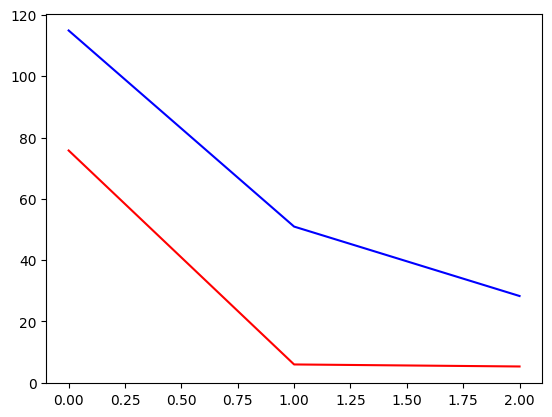

In [20]:
train.train('./model.pth')

In [ ]:
# aumentando learning rate
train = Train(model, train_loader, val_loader, epochs=100, patience=20, learning_rate=0.01)

# inicializando os pessos
train.init_weight()

In [ ]:
train.train('./model.pth')

In [ ]:
# aumentando learning rate
train = Train(model, train_loader, val_loader, epochs=500, patience=100, learning_rate=0.01)

# inicializando os pessos
train.init_weight()

In [ ]:
train.train('./model.pth')

### Modelo 2 - 1 hidden layer

In [17]:
# instanciando modelo
model = NeuralNetwork(n_hidden_layers=1)
print(model)

# instanciando classe de treino
train = Train(model, train_loader, val_loader, epochs=100, patience=20, learning_rate=0.001)

# inicializando os pessos
train.init_weight()

NeuralNetwork(
  (input_layer): Sequential(
    (0): Linear(in_features=11, out_features=16, bias=True)
    (1): ReLU()
  )
  (hidden_layers): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): ReLU()
  )
  (output_layer): Linear(in_features=16, out_features=3, bias=True)
)


In [ ]:
train.train('./model.pth')

In [ ]:
# aumentando learning rate
train = Train(model, train_loader, val_loader, epochs=100, patience=20, learning_rate=0.01)

# inicializando os pessos
train.init_weight()

In [ ]:
train.train('./model.pth')

In [ ]:
# aumentando learning rate
train = Train(model, train_loader, val_loader, epochs=500, patience=100, learning_rate=0.01)

# inicializando os pessos
train.init_weight()

In [ ]:
train.train('./model.pth')

### Modelo 2 - 1 hidden layer

In [17]:
# instanciando modelo
model = NeuralNetwork(n_hidden_layers=1)
print(model)

# instanciando classe de treino
train = Train(model, train_loader, val_loader, epochs=100, patience=20, learning_rate=0.001)

# inicializando os pessos
train.init_weight()

NeuralNetwork(
  (input_layer): Sequential(
    (0): Linear(in_features=11, out_features=16, bias=True)
    (1): ReLU()
  )
  (hidden_layers): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): ReLU()
  )
  (output_layer): Linear(in_features=16, out_features=3, bias=True)
)


In [ ]:
train.train('./model.pth')

In [ ]:
# aumentando learning rate
train = Train(model, train_loader, val_loader, epochs=100, patience=20, learning_rate=0.01)

# inicializando os pessos
train.init_weight()

In [ ]:
train.train('./model.pth')

### Modelo 3 - 2 hidden layer

In [18]:
# instanciando modelo
model = NeuralNetwork(n_hidden_layers=2)
print(model)

# instanciando classe de treino
train = Train(model, train_loader, val_loader, epochs=100, patience=20, learning_rate=0.001)

# inicializando os pessos
train.init_weight()

NeuralNetwork(
  (input_layer): Sequential(
    (0): Linear(in_features=11, out_features=16, bias=True)
    (1): ReLU()
  )
  (hidden_layers): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
  )
  (output_layer): Linear(in_features=16, out_features=3, bias=True)
)


In [ ]:
train.train('./model.pth')

In [ ]:
# aumentando learning rate
train = Train(model, train_loader, val_loader, epochs=100, patience=20, learning_rate=0.01)

# inicializando os pessos
train.init_weight()

In [ ]:
train.train('./model.pth')

In [ ]:
# aumentando learning rate
train = Train(model, train_loader, val_loader, epochs=500, patience=100, learning_rate=0.01)

# inicializando os pessos
train.init_weight()

In [ ]:
train.train('./model.pth')